In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import json
import seaborn as sns
from collections import Counter
import nltk
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

C:\Users\owltu\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\owltu\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

#### Data Cleaning

In [17]:
yelp = pd.read_csv("yelp_balanced.csv")

In [18]:
yelp

,Unnamed: 0,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,111089,S3r97tHMkzR4O-tiIIzwOQ,r0GLQAawvHXUd-xZow-fWQ,mzREMIknfmagJugibXrCsQ,4,2017-04-14,"Food is tasty, it's usually busy, but there al...",0,0,0
1,674606,lZTYcQXntUsLptcWCqyhmg,bDs5_ek9esUkgxFm1jFxfg,aZG9Hp8fdgzq37iuB1QTYg,1,2017-10-01,Probably one of the worst experiences I've eve...,1,0,0
2,3329480,sStohXbOEdPyrutK3zJSmg,mus1d8cMxuEJmP0zfV19hg,I4Nr-MVc26qWr08-S3Q1ow,4,2017-01-19,I was looking for a place to grab a quick bite...,0,0,0
3,3641542,Pvw7lbeyGGLVALvK0DwgDA,qrwH8z4nNUabqlsnwNoDCg,vAbRNF0hJt91oCUpm_sdKw,3,2014-01-09,"Meh, fish was a bit rubbery for $34 swordfish....",1,0,0
4,2054056,XWN8BVvLwcmgEW6xZuOKpg,cYvO88wNlRc_gd03caBZ7Q,sNVGdeOPeitJ3OWUQBINzQ,4,2012-02-29,I've heard so much about this place.. and I mu...,2,2,3
...,...,...,...,...,...,...,...,...,...,...
149995,4137925,-EfkdreWNtk2MsHYE-nv7Q,vRG_9sj-iFliiUKqZCVGRA,Rb2s2-2kIvbPXnPEuM_OBg,1,2015-06-13,Never ever will I dine or drink in this place ...,0,0,0
149996,2702734,VcLVmt3nMU4EW3D50SG2tA,NIeLhx7kQ7KROhH2zs5qYw,148d7J-cFejkhYV89y3Jsg,4,2010-11-28,It's 3.5 stars for me this time since the ride...,2,0,0
149997,4604320,D4EnQl1-Vgpfx0P-wxZM6w,RV0ljoUuwfkPYtzvT03W9g,sqFU1WIFbH_rrJJVHR4Z0g,5,2016-10-17,Good selection of produce at great prices. Gre...,1,0,0
149998,2349976,wGtYjLJL-O6TNA5EILPaLQ,4qyy_D9QSrRcGIrUekjXBw,75uWBy0mNnvSa6Wrrv7Xtg,5,2016-10-22,Absolutely no pressure!! We needed a quick ea...,0,0,0


In [19]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df

yelp = clean_text(yelp, 'text', 'text_clean')

In [20]:
yelp_basic = yelp[['stars', 'text_clean']]

In [21]:
yelp_basic.shape

(150000, 2)

In [22]:
yelp_features = yelp[['stars', 'text_clean', 'useful', 'funny', 'cool']]

In [23]:
df_train_raw, df_test = train_test_split(yelp_features, test_size=0.2, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=0.2,
                                        random_state=42, shuffle=True)

df_train = df_train_raw

In [24]:
def extract_features(df_train, df_dev, df_test):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_train = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    x_dev = vectorizer.transform(df_dev.loc[:, 'text_clean'].values.astype('U'))
    x_test = vectorizer.transform(df_test.loc[:, 'text_clean'].values.astype('U'))
    y_train = df_train.loc[:, 'stars'].tolist()
    y_dev = df_dev.loc[:, 'stars'].tolist()
    y_test = df_test.loc[:, 'stars'].tolist()
    return x_train, x_dev, x_test, y_train, y_dev, y_test

In [25]:
x_train, x_dev, x_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

In [26]:
useful = df_train.loc[:, 'useful'].tolist()
funny = df_train.loc[:, 'funny'].tolist()
cool = df_train.loc[:, 'cool'].tolist()

#### Assess Model Performance

In [27]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))

    disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
    plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

In [28]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    evaluate_model_Xy(model, x_train, y_train, label="Training", model_name=model_name)
    evaluate_model_Xy(model, x_dev, y_dev, label="Validation", model_name=model_name)
    evaluate_model_Xy(model, x_test, y_test, label="Testing", model_name=model_name)

#### Naive Bayes

In [29]:
clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)
clf_nb.fit(x_train, y_train)


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7736458333333334

              precision    recall  f1-score   support

           1     0.7202    0.8051    0.7603     19222
           2     0.7490    0.7084    0.7281     19184
           3     0.8019    0.7625    0.7817     19146
           4     0.7465    0.8270    0.7847     19259
           5     0.8724    0.7650    0.8152     19189

    accuracy                         0.7736     96000
   macro avg     0.7780    0.7736    0.7740     96000
weighted avg     0.7779    0.7736    0.7740     96000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


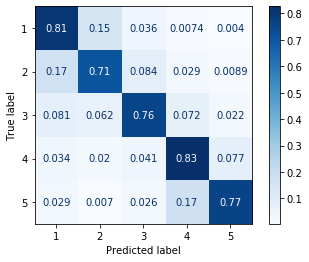


Validation Set
Accuracy: 0.549625

              precision    recall  f1-score   support

           1     0.6220    0.6988    0.6582      4867
           2     0.4694    0.4373    0.4527      4782
           3     0.4689    0.4516    0.4601      4867
           4     0.4832    0.5764    0.5257      4724
           5     0.7400    0.5836    0.6526      4760

    accuracy                         0.5496     24000
   macro avg     0.5567    0.5495    0.5499     24000
weighted avg     0.5566    0.5496    0.5499     24000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


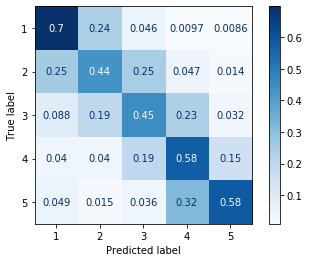


Testing Set
Accuracy: 0.5472

              precision    recall  f1-score   support

           1     0.6136    0.7037    0.6556      5883
           2     0.4807    0.4358    0.4572      6048
           3     0.4636    0.4500    0.4567      6009
           4     0.4825    0.5826    0.5278      6018
           5     0.7346    0.5677    0.6405      6042

    accuracy                         0.5472     30000
   macro avg     0.5550    0.5480    0.5475     30000
weighted avg     0.5548    0.5472    0.5471     30000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


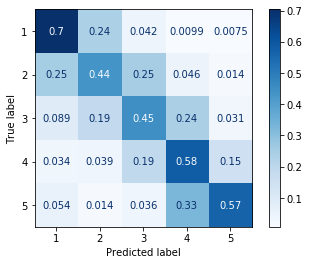

In [30]:
evaluate_model(clf_nb, model_name="nb")

#### SVM

In [41]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [42]:
clf_sgd.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 0.11, NNZs: 163998, Bias: -0.006264, T: 86400, Avg. loss: 0.461948
Total training time: 0.06 seconds.
Norm: 0.11, NNZs: 164962, Bias: -0.005723, T: 86400, Avg. loss: 0.529879
Total training time: 0.06 seconds.
Norm: 0.11, NNZs: 165174, Bias: -0.005459, T: 86400, Avg. loss: 0.528260
Total training time: 0.05 seconds.
Norm: 0.11, NNZs: 164700, Bias: -0.006037, T: 86400, Avg. loss: 0.472364
Total training time: 0.07 seconds.
Norm: 0.11, NNZs: 164543, Bias: -0.005905, T: 86400, Avg. loss: 0.517484
Total training time: 0.06 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.11, NNZs: 164418, Bias: -0.006360, T: 172800, Avg. loss: 0.433614
Total training time: 0.17 seconds.
Norm: 0.11, NNZs: 165088, Bias: -0.005834, T: 172800, Avg. loss: 0.496397
Total training time: 0.17 seconds.
Norm: 0.11, NNZs: 164813, Bias: -0.006010, T: 172800, Avg. loss: 0.485552
Total training time: 0.16 seconds.
Norm: 0.11, NNZs: 16491

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

Training Set
Accuracy: 0.8271458333333334

              precision    recall  f1-score   support

           1     0.7236    0.9351    0.8159     19222
           2     0.8801    0.7144    0.7886     19184
           3     0.8917    0.7574    0.8191     19146
           4     0.8349    0.8270    0.8309     19259
           5     0.8543    0.9015    0.8772     19189

    accuracy                         0.8271     96000
   macro avg     0.8369    0.8271    0.8264     96000
weighted avg     0.8368    0.8271    0.8264     96000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


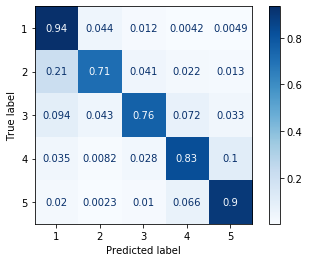


Validation Set
Accuracy: 0.536375

              precision    recall  f1-score   support

           1     0.5613    0.8050    0.6614      4867
           2     0.4818    0.3453    0.4022      4782
           3     0.4730    0.3403    0.3958      4867
           4     0.4676    0.5040    0.4851      4724
           5     0.6534    0.6863    0.6695      4760

    accuracy                         0.5364     24000
   macro avg     0.5274    0.5362    0.5228     24000
weighted avg     0.5274    0.5364    0.5228     24000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


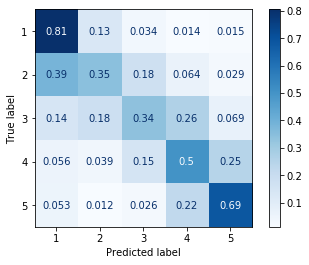


Testing Set
Accuracy: 0.5388333333333334

              precision    recall  f1-score   support

           1     0.5593    0.8171    0.6640      5883
           2     0.5042    0.3532    0.4154      6048
           3     0.4760    0.3438    0.3993      6009
           4     0.4690    0.5096    0.4885      6018
           5     0.6501    0.6768    0.6632      6042

    accuracy                         0.5388     30000
   macro avg     0.5317    0.5401    0.5261     30000
weighted avg     0.5317    0.5388    0.5255     30000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


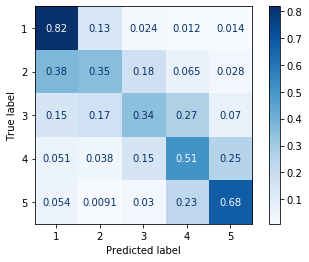

In [43]:
evaluate_model(clf_sgd, model_name="sgd")